In [5]:
import pandas as pd
import numpy as np
import os
from scipy.cluster.vq import whiten
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage,fcluster
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.vq import kmeans, vq
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import nltk
from collections import Counter
import string
import seaborn as sns
%matplotlib inline
import datetime
from sklearn.metrics import accuracy_score,confusion_matrix,precision_score,recall_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [6]:
sheet_to_df_map = pd.read_excel('online_retail_II.xlsx', sheet_name=None)
online_retailer = pd.concat(sheet_to_df_map, axis=0, ignore_index=True)

In [7]:
online_retailer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [8]:
online_retailer.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [9]:
online_retailer.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [10]:
#Understanding and cleaning data
#1. rows with less than 0 quantity, are cancelled orders
online_retailer[online_retailer['Quantity']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [11]:
# rows with negative price are bad debt adjustments
online_retailer[online_retailer['Price']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [12]:
#2. remove rows without Customer ID
online_retailer_1=online_retailer.dropna(subset=['Customer ID'])
online_retailer_1=online_retailer_1.drop(columns=['Invoice','Description','StockCode'])

In [13]:
online_retailer_1.describe()

,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


In [14]:
#online_retailer_1['Amount']=online_retailer_1.Price* online_retailer_1.Quantity
online_retailer_1.loc[:,'Amount'] = online_retailer_1.Price* online_retailer_1.Quantity

In [15]:
online_retailer_1.head()

,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [16]:
# remove rows without Amount negative
online_retailer_2=online_retailer_1.copy()
online_retailer_2=online_retailer_2.loc[(online_retailer_2['Amount']>0)&(online_retailer_2['Country']=="United Kingdom")]
online_retailer_2.describe()

,Quantity,Price,Customer ID,Amount
count,725250.000000,725250.000000,725250.000000,725250.000000
mean,12.003189,3.056777,15559.119094,20.300789
std,140.796321,25.165512,1593.844795,233.946130
min,1.000000,0.001000,12346.000000,0.001000
25%,2.000000,1.250000,14209.000000,4.200000
50%,4.000000,1.950000,15555.000000,10.200000
75%,12.000000,3.750000,16938.000000,17.700000
max,80995.000000,10953.500000,18287.000000,168469.600000


In [17]:
online_retailer_2.info

<bound method DataFrame.info of          Quantity         InvoiceDate  Price  Customer ID         Country  \
0              12 2009-12-01 07:45:00   6.95      13085.0  United Kingdom   
1              12 2009-12-01 07:45:00   6.75      13085.0  United Kingdom   
2              12 2009-12-01 07:45:00   6.75      13085.0  United Kingdom   
3              48 2009-12-01 07:45:00   2.10      13085.0  United Kingdom   
4              24 2009-12-01 07:45:00   1.25      13085.0  United Kingdom   
...           ...                 ...    ...          ...             ...   
1067350        12 2011-12-09 12:31:00   1.95      15804.0  United Kingdom   
1067351         8 2011-12-09 12:49:00   2.95      13113.0  United Kingdom   
1067352        24 2011-12-09 12:49:00   1.25      13113.0  United Kingdom   
1067353        24 2011-12-09 12:49:00   8.95      13113.0  United Kingdom   
1067354        10 2011-12-09 12:49:00   7.08      13113.0  United Kingdom   

         Amount  
0          83.4  
1      

In [18]:
#Invoice Date and Customer ID format change
online_retailer_2.InvoiceDate = pd.to_datetime(online_retailer_2.InvoiceDate)
online_retailer_2['Customer ID']=online_retailer_2['Customer ID'].apply(str)

In [19]:
online_retailer_2.head()

,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [20]:
reference_date = online_retailer_2.InvoiceDate.max() + datetime.timedelta(days = 1)
online_retailer_2['days_from_last_purchase'] = (reference_date - 
online_retailer_2.InvoiceDate).astype('timedelta64[D]')
lastpurchase_day = online_retailer_2[['Customer ID','days_from_last_purchase']].groupby('Customer ID').min().reset_index()
lastpurchase_day.rename(columns={'days_from_last_purchase':'recency'}, inplace=True)

In [21]:
lastpurchase_day.head()

,Customer ID,recency
0,12346.0,326.0
1,12608.0,405.0
2,12745.0,487.0
3,12746.0,541.0
4,12747.0,2.0


C:\Users\rayanoothalav\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


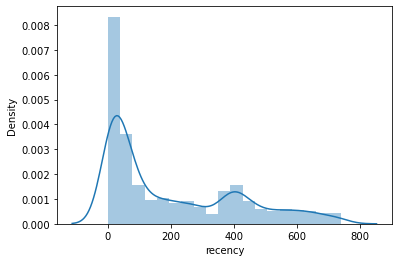

In [22]:
#Recency distribution plot
x=lastpurchase_day['recency']
ax=sns.distplot(x)

In [23]:
# Amount spent by each customer
customer_spending=pd.DataFrame(online_retailer_2.groupby('Customer ID')['Amount'].sum())
customer_spending=customer_spending.rename(columns={'Amount': 'Spending'})
customer_spending=customer_spending.reset_index()
customer_spending.head()

,Customer ID,Spending
0,12346.0,77556.46
1,12608.0,415.79
2,12745.0,723.85
3,12746.0,254.55
4,12747.0,9276.54


In [24]:
customer_spending.describe()

,Spending
count,5350.000000
mean,2751.990190
std,12080.466564
min,2.950000
25%,336.167500
50%,849.910000
75%,2214.905000
max,608821.650000


C:\Users\rayanoothalav\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


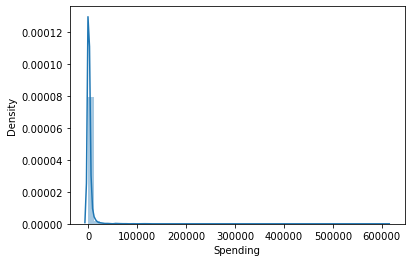

In [25]:
#Monetery distribution plot
x=customer_spending['Spending']
ax=sns.distplot(x)

In [26]:
customer_spending.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5350 entries, 0 to 5349
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5350 non-null   object 
 1   Spending     5350 non-null   float64
dtypes: float64(1), object(1)
memory usage: 83.7+ KB


In [27]:
No_of_times=pd.DataFrame(online_retailer_2.groupby('Customer ID')['InvoiceDate'].nunique())
No_of_times = No_of_times.rename(columns={'InvoiceDate': 'Purchase_Frequency'})
No_of_times = No_of_times.reset_index()
No_of_times.head()

,Customer ID,Purchase_Frequency
0,12346.0,12
1,12608.0,1
2,12745.0,2
3,12746.0,1
4,12747.0,26


In [28]:
No_of_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5350 entries, 0 to 5349
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         5350 non-null   object
 1   Purchase_Frequency  5350 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 83.7+ KB


In [29]:
No_of_times.describe()

,Purchase_Frequency
count,5350.000000
mean,6.248037
std,11.899513
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,337.000000


C:\Users\rayanoothalav\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


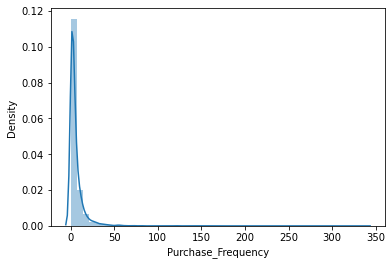

In [30]:
#Frequency of purchase distribution plot
x=No_of_times['Purchase_Frequency']
ax=sns.distplot(x)

In [31]:
#Each customers has purchased on average apprx. 7.5 times in 2 years, minimum 1 and maximum 508 times

In [32]:
segment_2=[lastpurchase_day,customer_spending, No_of_times]
import functools as ft
segment_2_final = ft.reduce(lambda left, right: pd.merge(left, right, on='Customer ID'), segment_2)

In [33]:
segment_2_final.head()

,Customer ID,recency,Spending,Purchase_Frequency
0,12346.0,326.0,77556.46,12
1,12608.0,405.0,415.79,1
2,12745.0,487.0,723.85,2
3,12746.0,541.0,254.55,1
4,12747.0,2.0,9276.54,26


In [34]:
segment_2_final.describe()

,recency,Spending,Purchase_Frequency
count,5350.000000,5350.000000,5350.000000
mean,203.000935,2751.990190,6.248037
std,209.959231,12080.466564,11.899513
min,1.000000,2.950000,1.000000
25%,26.000000,336.167500,1.000000
50%,98.500000,849.910000,3.000000
75%,382.000000,2214.905000,7.000000
max,739.000000,608821.650000,337.000000


In [35]:
###Calculating quantile values
quintiles = segment_2_final[['recency', 'Spending', 'Purchase_Frequency']].quantile([.2, .25, .3, .35, .4, .5, .6, .7, .8, .9]).to_dict()
###Benchmark to give score for recency indicator
def r_score(r):
    if r < quintiles['recency'][.2]:
        return 3 
    elif r < quintiles['recency'][.8]:
        return 2
    else: 
        return 1
###Benchmark to give score for frequency & monetary indicator.   
def fm_score(f): 
    if f > quintiles['Purchase_Frequency'][.8]:
        return 3
    elif f > quintiles['Purchase_Frequency'][.2]: 
        return 2
    else: 
        return 1 

In [36]:
rfm2 = segment_2_final.copy()
rfm2['r_score'] = rfm2.recency.apply(lambda x: r_score(x))
rfm2['f_score'] = rfm2.Purchase_Frequency.apply(lambda x: fm_score(x))
rfm2['m_score'] = rfm2.Spending.apply(lambda x: fm_score(x))
rfm2['rfm'] = rfm2['r_score'].map(str)+rfm2['f_score'].map(str) + rfm2['m_score'].map(str)
rfm2['rfm_scores']=rfm2[['r_score','f_score','m_score']].sum(axis=1)

In [37]:
rfm2.head()

,Customer ID,recency,Spending,Purchase_Frequency,r_score,f_score,m_score,rfm,rfm_scores
0,12346.0,326.0,77556.46,12,2,3,3,233,8
1,12608.0,405.0,415.79,1,2,1,3,213,6
2,12745.0,487.0,723.85,2,1,2,3,123,6
3,12746.0,541.0,254.55,1,1,1,3,113,5
4,12747.0,2.0,9276.54,26,3,3,3,333,9


In [38]:
rfm2.describe()

,recency,Spending,Purchase_Frequency,r_score,f_score,m_score,rfm_scores
count,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000,5350.000000
mean,203.000935,2751.990190,6.248037,1.988785,1.919439,2.998879,6.907103
std,209.959231,12080.466564,11.899513,0.627668,0.680948,0.033473,1.126080
min,1.000000,2.950000,1.000000,1.000000,1.000000,2.000000,4.000000
25%,26.000000,336.167500,1.000000,2.000000,1.000000,3.000000,6.000000
50%,98.500000,849.910000,3.000000,2.000000,2.000000,3.000000,7.000000
75%,382.000000,2214.905000,7.000000,2.000000,2.000000,3.000000,8.000000
max,739.000000,608821.650000,337.000000,3.000000,3.000000,3.000000,9.000000


In [45]:
#1. RFM segments
###Loyal Customers, who are the champions of all the customers with highest score of RFM. 
rfm2_group1 = rfm2[rfm2['rfm']=='333']
rfm2_group1.loc[:,'Segment_name'] = 'champion'
rfm2_group1.loc[:,'cluster'] = 1
###Customers who have the most potential to become the Champions. They recently buy the products and they make their purchases quite frequently. Moreover, the amount they spent is quite great. 
rfm2_group2 = rfm2[rfm2['rfm'].str.contains('332|331|323|313')] 
rfm2_group2.loc[:,'Segment_name'] = 'potential1'
rfm2_group2.loc[:,'cluster'] = 2
###Customers whose frequency score and monetary score are slightly lower than potential 1 group
#rfm2_group3 = rfm2[rfm2['rfm'].str.contains('321|322|311|312')] 
#rfm2_group3.loc[:,'Segment_name'] = 'potential2'
#rfm2_group3.loc[:,'cluster'] = 3
###Customers who used to pay a lot of money and bought frequently. They did not purchase recently. 
rfm2_group4 = rfm2[rfm2['rfm'].str.contains('233')]
rfm2_group4.loc[:,'Segment_name'] = 'needing_attention1'
rfm2_group4.loc[:,'cluster'] = 4
###Customers who did not buy recently nor frequently made purchases.
rfm2_group5 = rfm2[rfm2['rfm'].str.contains('223|213|212|231|232|211|221|222')]
rfm2_group5.loc[:,'Segment_name'] = 'needing_attention2'
rfm2_group5.loc[:,'cluster'] = 5
###Customers who haven't bought recently. However, once in a while, they do spend lot of money
rfm2_group6 = rfm2[rfm2['rfm'].str.contains('132|123|113|133')]
rfm2_group6.loc[:,'Segment_name'] = 'lost1'
rfm2_group6.loc[:,'cluster'] = 6
###Customers who churn
rfm2_group7 = rfm2[rfm2['rfm'].str.contains('111|112|121|122|131')]
rfm2_group7.loc[:,'Segment_name'] = 'lost2'
rfm2_group7.loc[:,'cluster'] = 7

In [46]:
import pandas as pd
rfm2_together=pd.concat([rfm2_group1,rfm2_group2,rfm2_group4,rfm2_group5,rfm2_group6,rfm2_group7],axis=0)
rfm2_together.head()

,Customer ID,recency,Spending,Purchase_Frequency,r_score,f_score,m_score,rfm,rfm_scores,Segment_name,cluster
4,12747.0,2.0,9276.54,26,3,3,3,333,9,champion,1
5,12748.0,1.0,56599.39,337,3,3,3,333,9,champion,1
6,12749.0,4.0,6897.36,9,3,3,3,333,9,champion,1
9,12820.0,3.0,2689.52,11,3,3,3,333,9,champion,1
15,12826.0,3.0,2955.75,12,3,3,3,333,9,champion,1


In [47]:
rfm2_together.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5350 entries, 4 to 3017
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer ID         5350 non-null   object 
 1   recency             5350 non-null   float64
 2   Spending            5350 non-null   float64
 3   Purchase_Frequency  5350 non-null   int64  
 4   r_score             5350 non-null   int64  
 5   f_score             5350 non-null   int64  
 6   m_score             5350 non-null   int64  
 7   rfm                 5350 non-null   object 
 8   rfm_scores          5350 non-null   int64  
 9   Segment_name        5350 non-null   object 
 10  cluster             5350 non-null   int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 501.6+ KB


In [48]:
first=rfm2_together.groupby(['cluster','Segment_name'])['cluster'].count()
first.head(100)

cluster  Segment_name      
1        champion               503
2        potential1             521
4        needing_attention1     524
5        needing_attention2    2718
6        lost1                 1080
7        lost2                    4
Name: cluster, dtype: int64

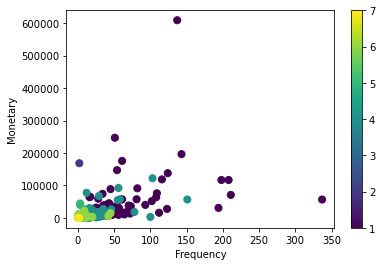

In [49]:
import matplotlib.pyplot as plt

# Scatter plot of Purchase_Frequency vs. Monetary
x = rfm2_together['Purchase_Frequency']
y = rfm2_together['Spending']
Cluster = rfm2_together['cluster']

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=50)

ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
plt.colorbar(scatter)

plt.show()

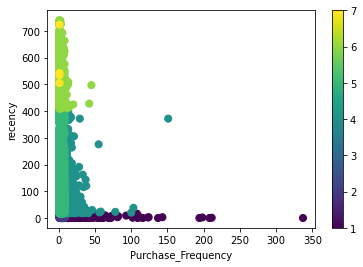

In [50]:
# Scatter plot of Recency vs. Frequency
x = rfm2_together['Purchase_Frequency']
y = rfm2_together['recency']
Cluster = rfm2_together['cluster']
#centers = rfm2_together.random(7, 2) 

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=50)
#for i,j in centers:
#    ax.scatter(i,j,s=50,c='red',marker='+')
ax.set_xlabel('Purchase_Frequency')
ax.set_ylabel('recency')
plt.colorbar(scatter)

plt.show()

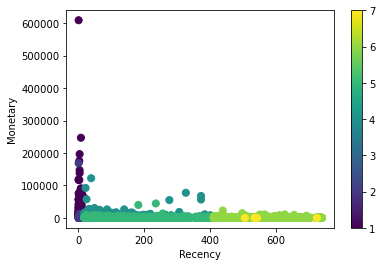

In [51]:
# Scatter plot of Recency vs. Monetary
x = rfm2_together['recency']
y = rfm2_together['Spending']
Cluster = rfm2_together['cluster']

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x,y,c=Cluster,s=50)

ax.set_xlabel('Recency')
ax.set_ylabel('Monetary')
plt.colorbar(scatter)

plt.show()

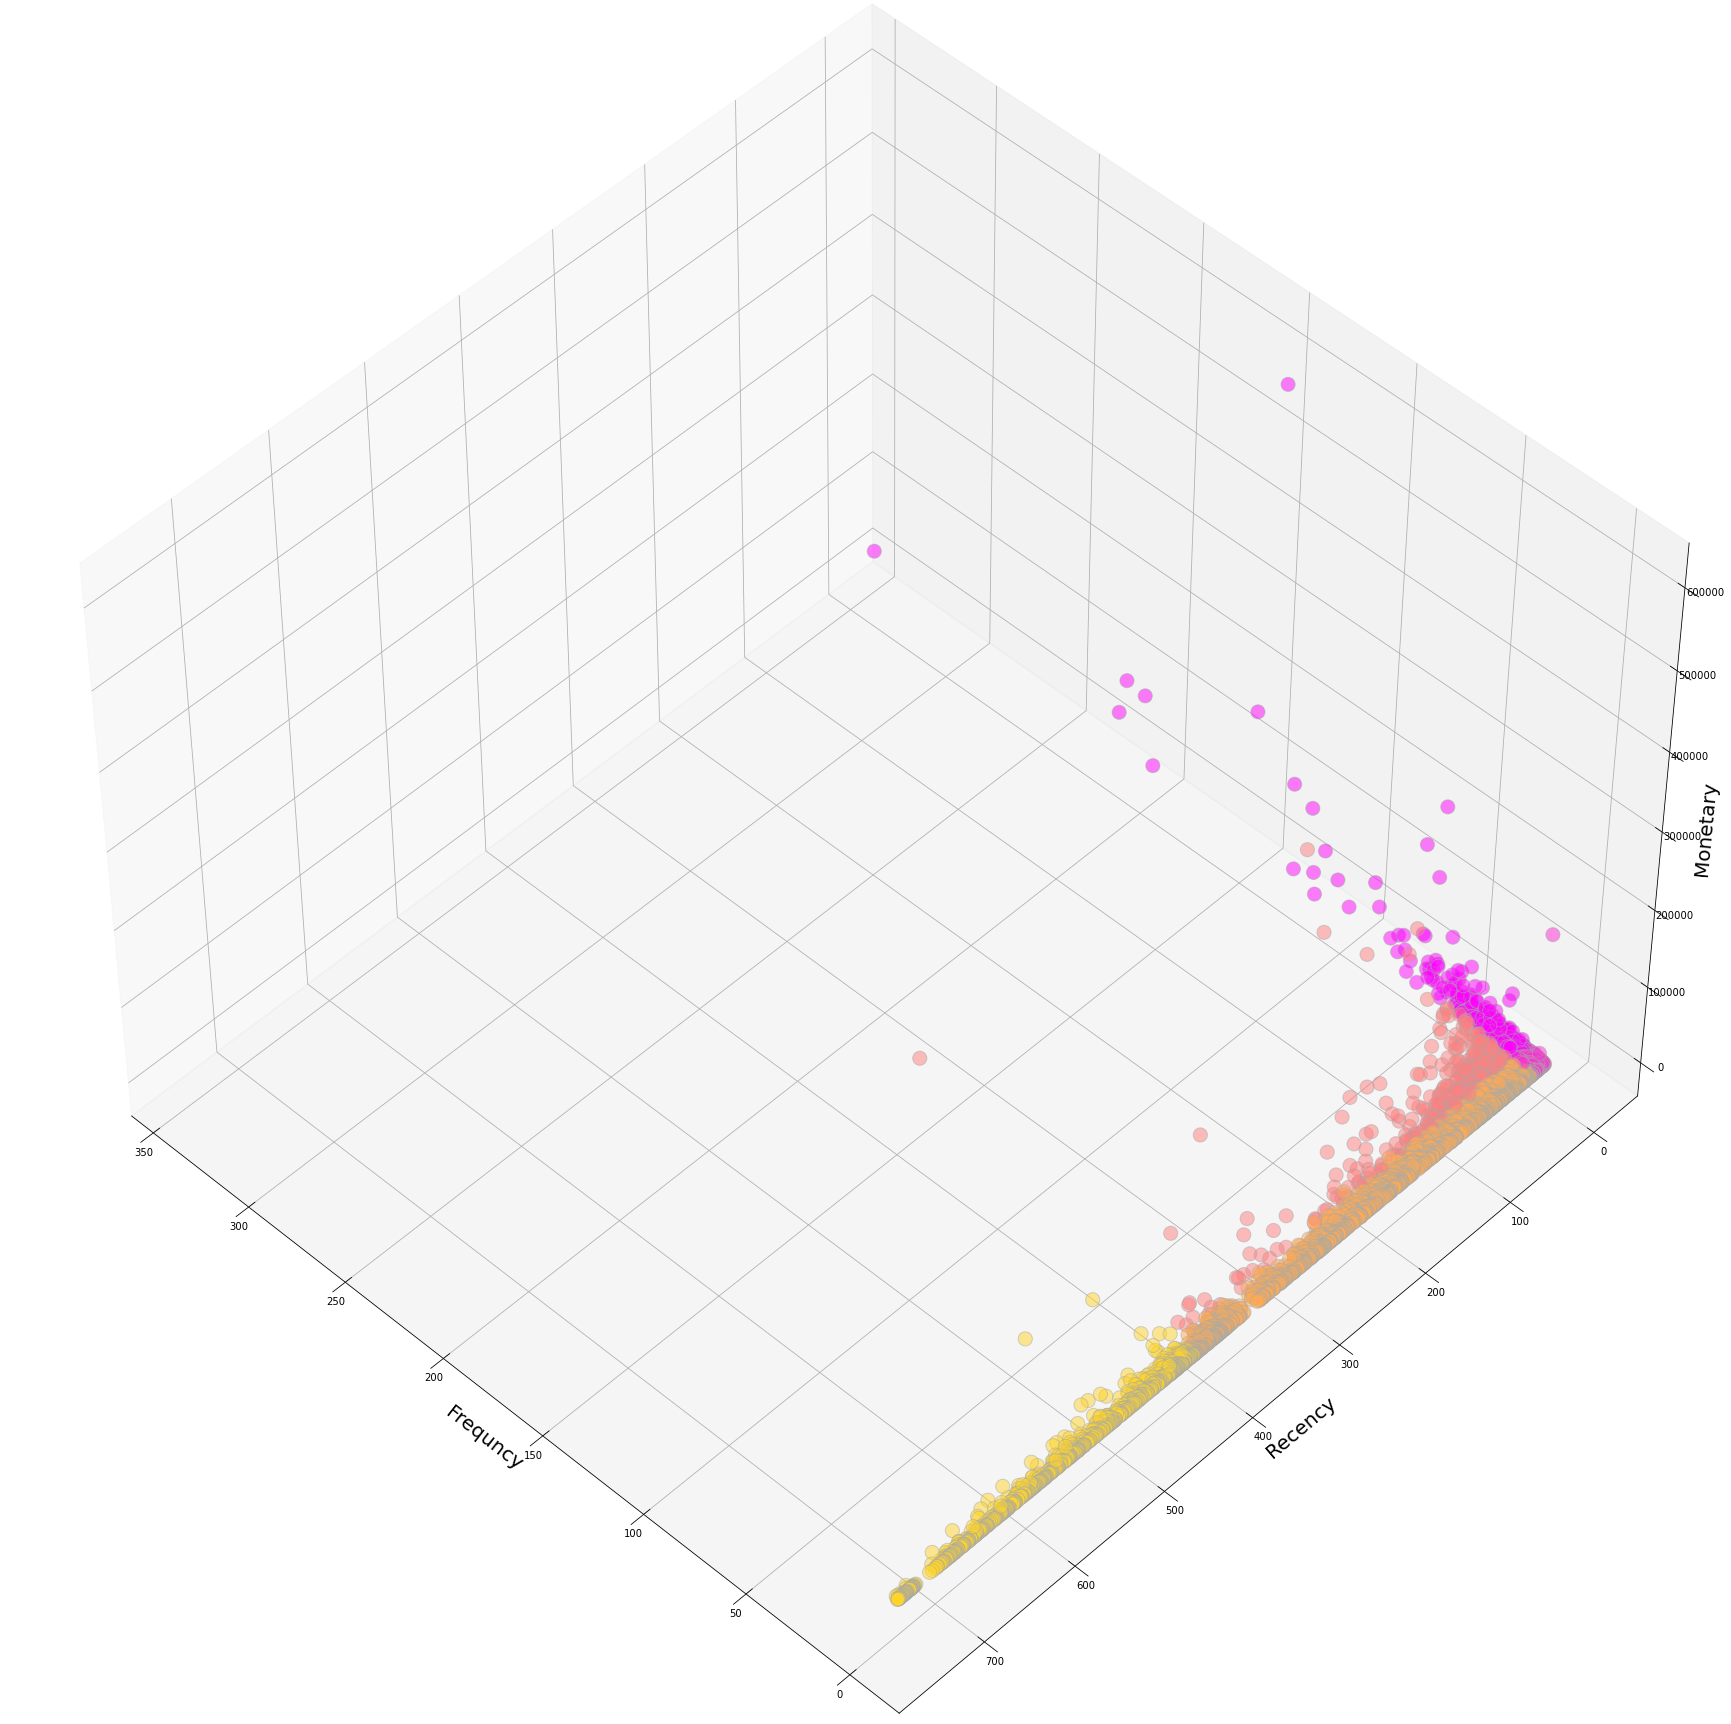

In [52]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"]=(25,25)
fig=plt.figure(1)
plt.clf()
ax=Axes3D(fig,rect=[0,0,.95,1], elev=48, azim=134)
plt.cla()
ax.scatter(rfm2_together['Purchase_Frequency'],rfm2_together['recency'],rfm2_together['Spending'],
           c=rfm2_together['cluster'],
          s=200,
          cmap='spring',
          alpha=0.5,
          edgecolor='darkgrey')
ax.set_xlabel('Frequncy',fontsize=20)
ax.set_ylabel('Recency',fontsize=20)
ax.set_zlabel('Monetary',fontsize=20)
plt.show()

<AxesSubplot:>

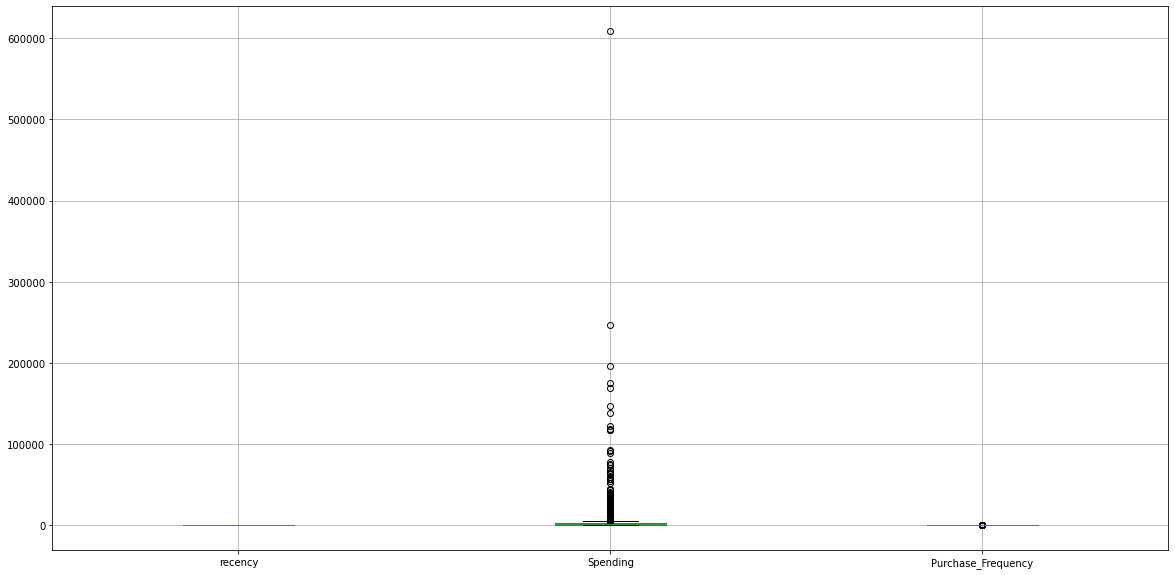

In [53]:
# Outliers exist in the data

rfm2_together.boxplot(column=['recency','Spending','Purchase_Frequency'], by=None, ax=None, fontsize=10, rot=0, grid=True, figsize=(20,10), layout=None, return_type=None, backend=None)

In [54]:
# remove outliers by normalizing
scaler=StandardScaler()
rfm2_normalized=rfm2_together[['Customer ID','Segment_name','Spending','Purchase_Frequency','recency']]
rfm2_normalized

,Customer ID,Segment_name,Spending,Purchase_Frequency,recency
4,12747.0,champion,9276.54,26,2.0
5,12748.0,champion,56599.39,337,1.0
6,12749.0,champion,6897.36,9,4.0
9,12820.0,champion,2689.52,11,3.0
15,12826.0,champion,2955.75,12,3.0
...,...,...,...,...,...
5348,18286.0,lost1,1296.43,2,477.0
950,13788.0,lost2,3.75,1,505.0
1244,14095.0,lost2,2.95,1,723.0
2157,15040.0,lost2,7.49,1,542.0


In [55]:
rfm3_scaled=rfm2_normalized
rfm3_scaled[["Spending", "Purchase_Frequency","recency"]] = scaler.fit_transform(
    rfm2_normalized[["Spending", "Purchase_Frequency","recency"]])

<ipython-input-55-114b6d44e56a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm3_scaled[["Spending", "Purchase_Frequency","recency"]] = scaler.fit_transform(
C:\Users\rayanoothalav\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


<AxesSubplot:>

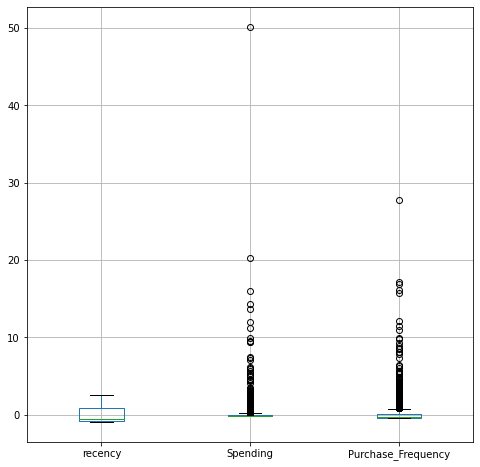

In [56]:
# after normalization
rfm3_scaled.boxplot(column=['recency','Spending','Purchase_Frequency'], by=None, ax=None, fontsize=10, rot=0, grid=True, figsize=(8,8), layout=None, return_type=None, backend=None)

In [57]:
#2. Elbow and K Means Clustering
#For Clustering with Categorical values

!pip install kmodes
import pandas as pd
from kmodes.kprototypes import KPrototypes

In [58]:
categorical_features_idx = [0, 1]
mark_array=rfm3_scaled.values

In [59]:
kproto = KPrototypes(n_clusters=4, verbose=2, max_iter=50).fit(mark_array, categorical=categorical_features_idx)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/50, moves: 2550, ncost: 10463.933377148813
Run: 1, iteration: 2/50, moves: 801, ncost: 9064.134223859523
Run: 1, iteration: 3/50, moves: 259, ncost: 8860.686254841938
Run: 1, iteration: 4/50, moves: 93, ncost: 8835.811928918993
Run: 1, iteration: 5/50, moves: 42, ncost: 8824.365030315532
Run: 1, iteration: 6/50, moves: 20, ncost: 8822.540505988201
Run: 1, iteration: 7/50, moves: 8, ncost: 8822.26072493408
Run: 1, iteration: 8/50, moves: 3, ncost: 8822.22683399228
Run: 1, iteration: 9/50, moves: 1, ncost: 8822.220943933722
Run: 1, iteration: 10/50, moves: 0, ncost: 8822.220943933722
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/50, moves: 1792, ncost: 9656.158184734466
Run: 2, iteration: 2/50, moves: 649, ncost: 8867.013283817892
Run: 2, iteration: 3/50, move

In [61]:
# Cluster Centroids
clusters = kproto.predict(mark_array, categorical=categorical_features_idx)
print(kproto.cluster_centroids_)

[['-0.08976865071039547' '-0.10739207478746526' '-0.557092822811137'
  '12821.0' 'needing_attention2']
 ['11.736077493156891' '10.629511455614752' '-0.8423101742560073'
  '12748.0' 'champion']
 ['0.9283882637572894' '1.8520010325367504' '-0.8329318429209451'
  '12747.0' 'champion']
 ['-0.17074901182926802' '-0.34583034517040884' '1.3595326860045598'
  '12608.0' 'lost1']]


In [62]:
rfm3_scaled['cluster'] = list(clusters)

<ipython-input-62-9063e3950446>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm3_scaled['cluster'] = list(clusters)


In [63]:
# sample Segment , Cluster of 4, Customer ID - breakdown
rfm3_scaled[rfm3_scaled['cluster']== 0].head()

,Customer ID,Segment_name,Spending,Purchase_Frequency,recency,cluster
6,12749.0,champion,0.343179,0.231288,-0.947896,0
9,12820.0,champion,-0.005172,0.399378,-0.952659,0
15,12826.0,champion,0.016868,0.483423,-0.952659,0
97,12913.0,champion,0.326911,0.567468,-0.943133,0
119,12935.0,champion,0.123506,0.735558,-0.957423,0


In [64]:
rfm3_scaled[rfm3_scaled['cluster']== 1].head()

,Customer ID,Segment_name,Spending,Purchase_Frequency,recency,cluster
5,12748.0,champion,4.457811,27.798019,-0.962186,1
270,13089.0,champion,9.436434,16.115776,-0.952659,1
857,13694.0,champion,16.038199,11.493306,-0.947896,1
960,13798.0,champion,6.050405,8.635779,-0.962186,1
1442,14298.0,champion,7.321801,6.366567,-0.928843,1


In [65]:
rfm3_scaled[rfm3_scaled['cluster']== 2].head()

,Customer ID,Segment_name,Spending,Purchase_Frequency,recency,cluster
4,12747.0,champion,0.540141,1.660052,-0.957423,2
28,12839.0,champion,0.605972,1.660052,-0.952659,2
30,12841.0,champion,0.396436,2.752636,-0.943133,2
62,12877.0,champion,0.016820,1.155782,-0.947896,2
85,12901.0,champion,1.233722,1.828142,-0.924080,2


In [66]:
rfm3_scaled[rfm3_scaled['cluster']== 3].head()

,Customer ID,Segment_name,Spending,Purchase_Frequency,recency,cluster
59,12872.0,needing_attention1,0.077281,0.483423,0.590642,3
386,13206.0,needing_attention1,0.465699,0.567468,0.938361,3
707,13542.0,needing_attention1,0.103829,0.903648,0.828805,3
856,13693.0,needing_attention1,-0.061276,0.231288,0.814516,3
1281,14134.0,needing_attention1,0.693031,0.735558,0.857385,3


In [67]:
# sum of square distances for clusters computed for numerical fields
rfm4_scaled = rfm3_scaled.iloc[:, [2,3, 4]].values
sum_of_sq_dist={}
for num_clusters in range(1,15):
    kmeans=KMeans(n_clusters=num_clusters,init='k-means++',max_iter=1000)
    kmeans.fit(rfm4_scaled)
    sum_of_sq_dist[num_clusters]=kmeans.inertia_

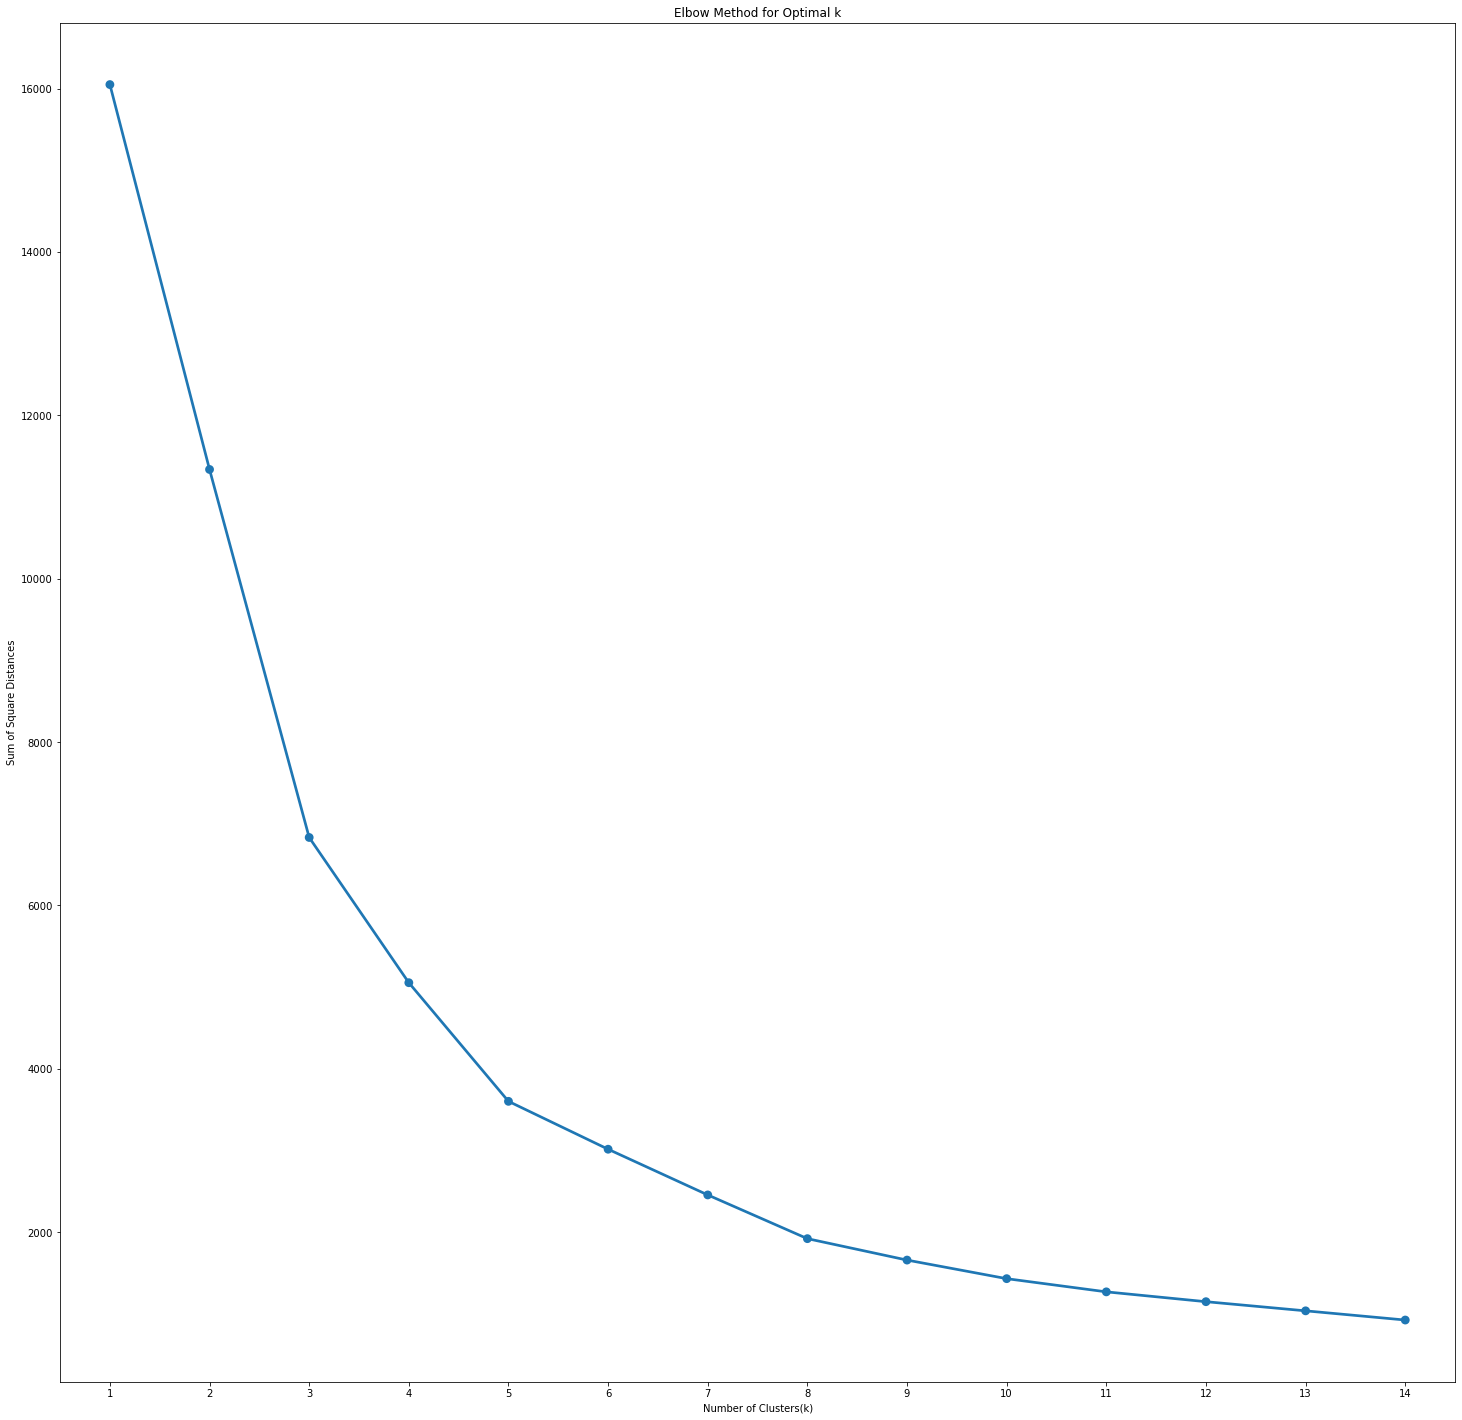

In [68]:
# Elbow Curve
sns.pointplot(x=list(sum_of_sq_dist.keys()),y=list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method for Optimal k')
plt.show()

In [71]:
#3. Silhouette Analysis
for num_clusters in range(2,15):
    kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(rfm4_scaled)
    cluster_labels=kmeans.labels_
    #silhouette score
    silhouette_avg=silhouette_score(rfm4_scaled,cluster_labels)
    print("For n_clusters={0},the silhouette score is {1}".format(num_clusters,silhouette_avg))

For n_clusters=2,the silhouette score is 0.5427383933423554
For n_clusters=3,the silhouette score is 0.5709408998925913
For n_clusters=4,the silhouette score is 0.5756265375828242
For n_clusters=5,the silhouette score is 0.5999459927700813
For n_clusters=6,the silhouette score is 0.5937624905154639
For n_clusters=7,the silhouette score is 0.5350453656163757
For n_clusters=8,the silhouette score is 0.5346261659994758
For n_clusters=9,the silhouette score is 0.4764734096744537
For n_clusters=10,the silhouette score is 0.4973912941046593
For n_clusters=11,the silhouette score is 0.4938293671036302
For n_clusters=12,the silhouette score is 0.4777990330924042
For n_clusters=13,the silhouette score is 0.49099801625143963
For n_clusters=14,the silhouette score is 0.468996663562025


In [74]:
# 4. KMeans clustering
# Based on silhouette score, 5 clusters has value closest to 1. Score 1 indicates clusters are well apart from each other and clearly distinguished 
# while 0 indicates clusters are indifferent, or we can say that the distance between clusters is not significant.
# K-means clustering
no_clusters=5
kproto = KPrototypes(n_clusters=no_clusters, verbose=2, max_iter=50).fit(mark_array, categorical=categorical_features_idx)
clusters = kproto.predict(mark_array, categorical=categorical_features_idx)
print(kproto.cluster_centroids_)
rfm3_scaled['KMeans_Cluster'] = list(clusters)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/50, moves: 1063, ncost: 8329.547081066996
Run: 1, iteration: 2/50, moves: 242, ncost: 8073.918083536362
Run: 1, iteration: 3/50, moves: 71, ncost: 8033.944019385351
Run: 1, iteration: 4/50, moves: 44, ncost: 8028.0084325654625
Run: 1, iteration: 5/50, moves: 9, ncost: 8027.838184786549
Run: 1, iteration: 6/50, moves: 2, ncost: 8027.83137421148
Run: 1, iteration: 7/50, moves: 0, ncost: 8027.83137421148
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations

<ipython-input-74-c5d3f38c2944>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm3_scaled['KMeans_Cluster'] = list(clusters)


In [75]:
rfm3_scaled.sort_values('Customer ID',ascending=False).reset_index()
rfm3_scaled.head(20)

,Customer ID,Segment_name,Spending,Purchase_Frequency,recency,cluster,KMeans_Cluster
4,12747.0,champion,0.540141,1.660052,-0.957423,2,1
5,12748.0,champion,4.457811,27.798019,-0.962186,1,2
6,12749.0,champion,0.343179,0.231288,-0.947896,0,0
9,12820.0,champion,-0.005172,0.399378,-0.952659,0,0
15,12826.0,champion,0.016868,0.483423,-0.952659,0,0
28,12839.0,champion,0.605972,1.660052,-0.952659,2,1
30,12841.0,champion,0.396436,2.752636,-0.943133,2,1
62,12877.0,champion,0.016820,1.155782,-0.947896,2,1
85,12901.0,champion,1.233722,1.828142,-0.924080,2,1
97,12913.0,champion,0.326911,0.567468,-0.943133,0,0


<ipython-input-80-557bd231b0a4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm3_scaled['Colors']=rfm3_scaled['KMeans_Cluster'].map(lambda p:Colors[p])


<Figure size 504x504 with 0 Axes>

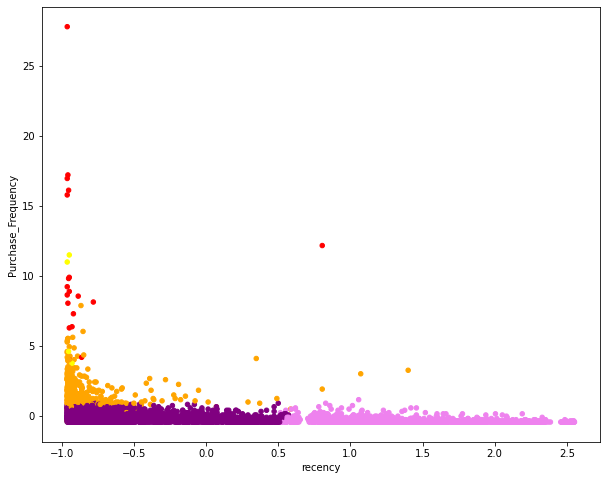

In [80]:
#scatter plot Frequency vs. Recency

plt.figure(figsize=(7,7))

Colors=["purple","orange","red","violet","yellow"]
rfm3_scaled['Colors']=rfm3_scaled['KMeans_Cluster'].map(lambda p:Colors[p])
ax=rfm3_scaled.plot(
    kind="scatter",
    x="recency",y="Purchase_Frequency",
    figsize=(10,8),
    c=rfm3_scaled['Colors']
)

<ipython-input-82-84ad9823e8c5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm3_scaled['Colors']=rfm3_scaled['KMeans_Cluster'].map(lambda p:Colors[p])


<Figure size 504x504 with 0 Axes>

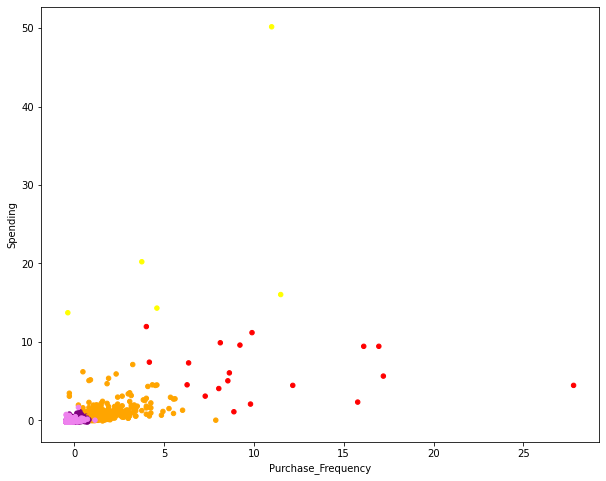

In [82]:
#scatter plot Frequency vs. Monetary

plt.figure(figsize=(7,7))

Colors=["purple","orange","red","violet","yellow"]
rfm3_scaled['Colors']=rfm3_scaled['KMeans_Cluster'].map(lambda p:Colors[p])
ax=rfm3_scaled.plot(
    kind="scatter",
    x="Purchase_Frequency",y="Spending",
    figsize=(10,8),
    c=rfm3_scaled['Colors']
)

<ipython-input-83-c6fbde978b10>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm3_scaled['Colors']=rfm3_scaled['KMeans_Cluster'].map(lambda p:Colors[p])


<Figure size 504x504 with 0 Axes>

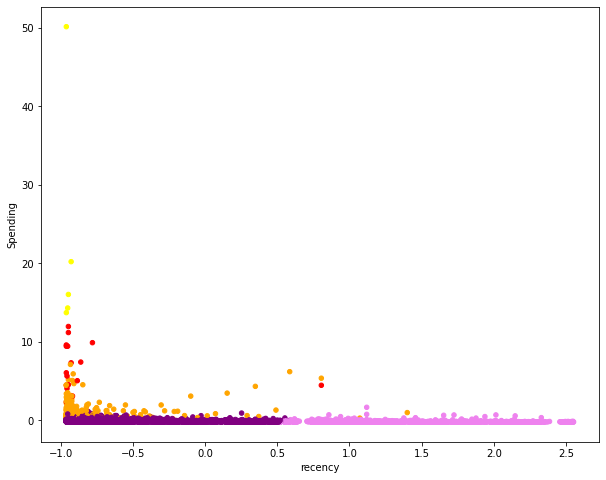

In [83]:
#scatter plot Recency vs. Monetary

plt.figure(figsize=(7,7))

Colors=["purple","orange","red","violet","yellow"]
rfm3_scaled['Colors']=rfm3_scaled['KMeans_Cluster'].map(lambda p:Colors[p])
ax=rfm3_scaled.plot(
    kind="scatter",
    x="recency",y="Spending",
    figsize=(10,8),
    c=rfm3_scaled['Colors']
)

<ipython-input-85-cf1c9fc135b7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm3_scaled['Colors']=rfm3_scaled['KMeans_Cluster'].map(lambda p:Colors[p])


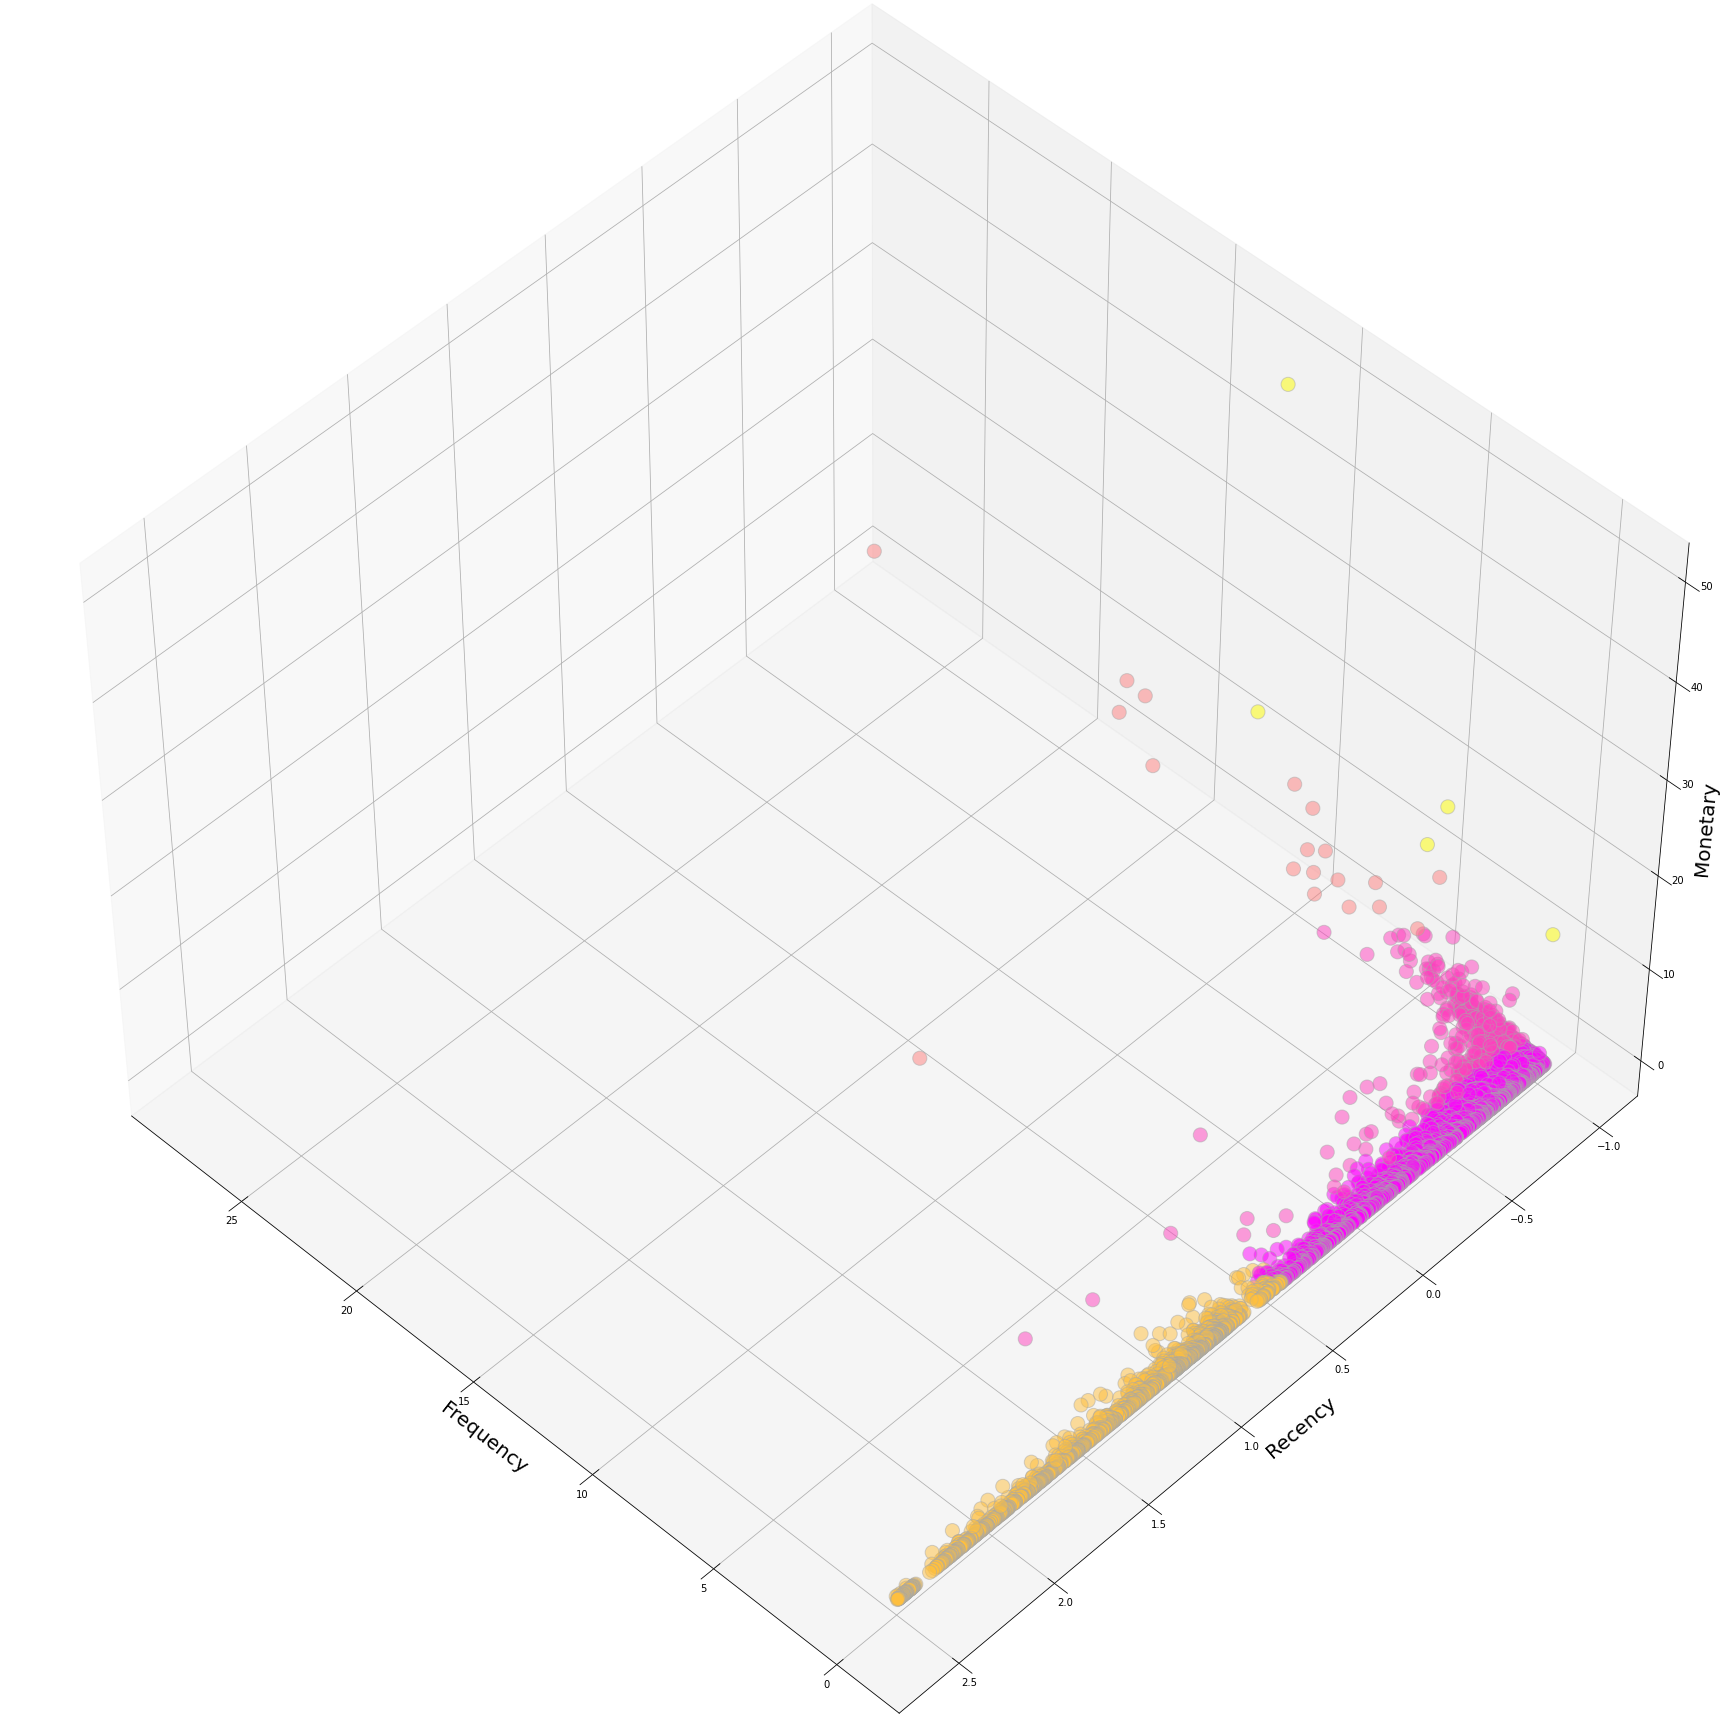

In [85]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"]=(25,25)
fig=plt.figure(1)
plt.clf()
ax=Axes3D(fig,rect=[0,0,.95,1], elev=48, azim=134)
plt.cla()
Colors=["purple","orange","red","violet","yellow"]
rfm3_scaled['Colors']=rfm3_scaled['KMeans_Cluster'].map(lambda p:Colors[p])
ax.scatter(rfm3_scaled['Purchase_Frequency'],rfm3_scaled['recency'],rfm3_scaled['Spending'],
           c=rfm3_scaled['KMeans_Cluster'],
          s=200,
          cmap='spring',
          alpha=0.5,
          edgecolor='darkgrey')
ax.set_xlabel('Frequency',fontsize=20)
ax.set_ylabel('Recency',fontsize=20)
ax.set_zlabel('Monetary',fontsize=20)
plt.show()

<AxesSubplot:xlabel='KMeans_Cluster', ylabel='Spending'>

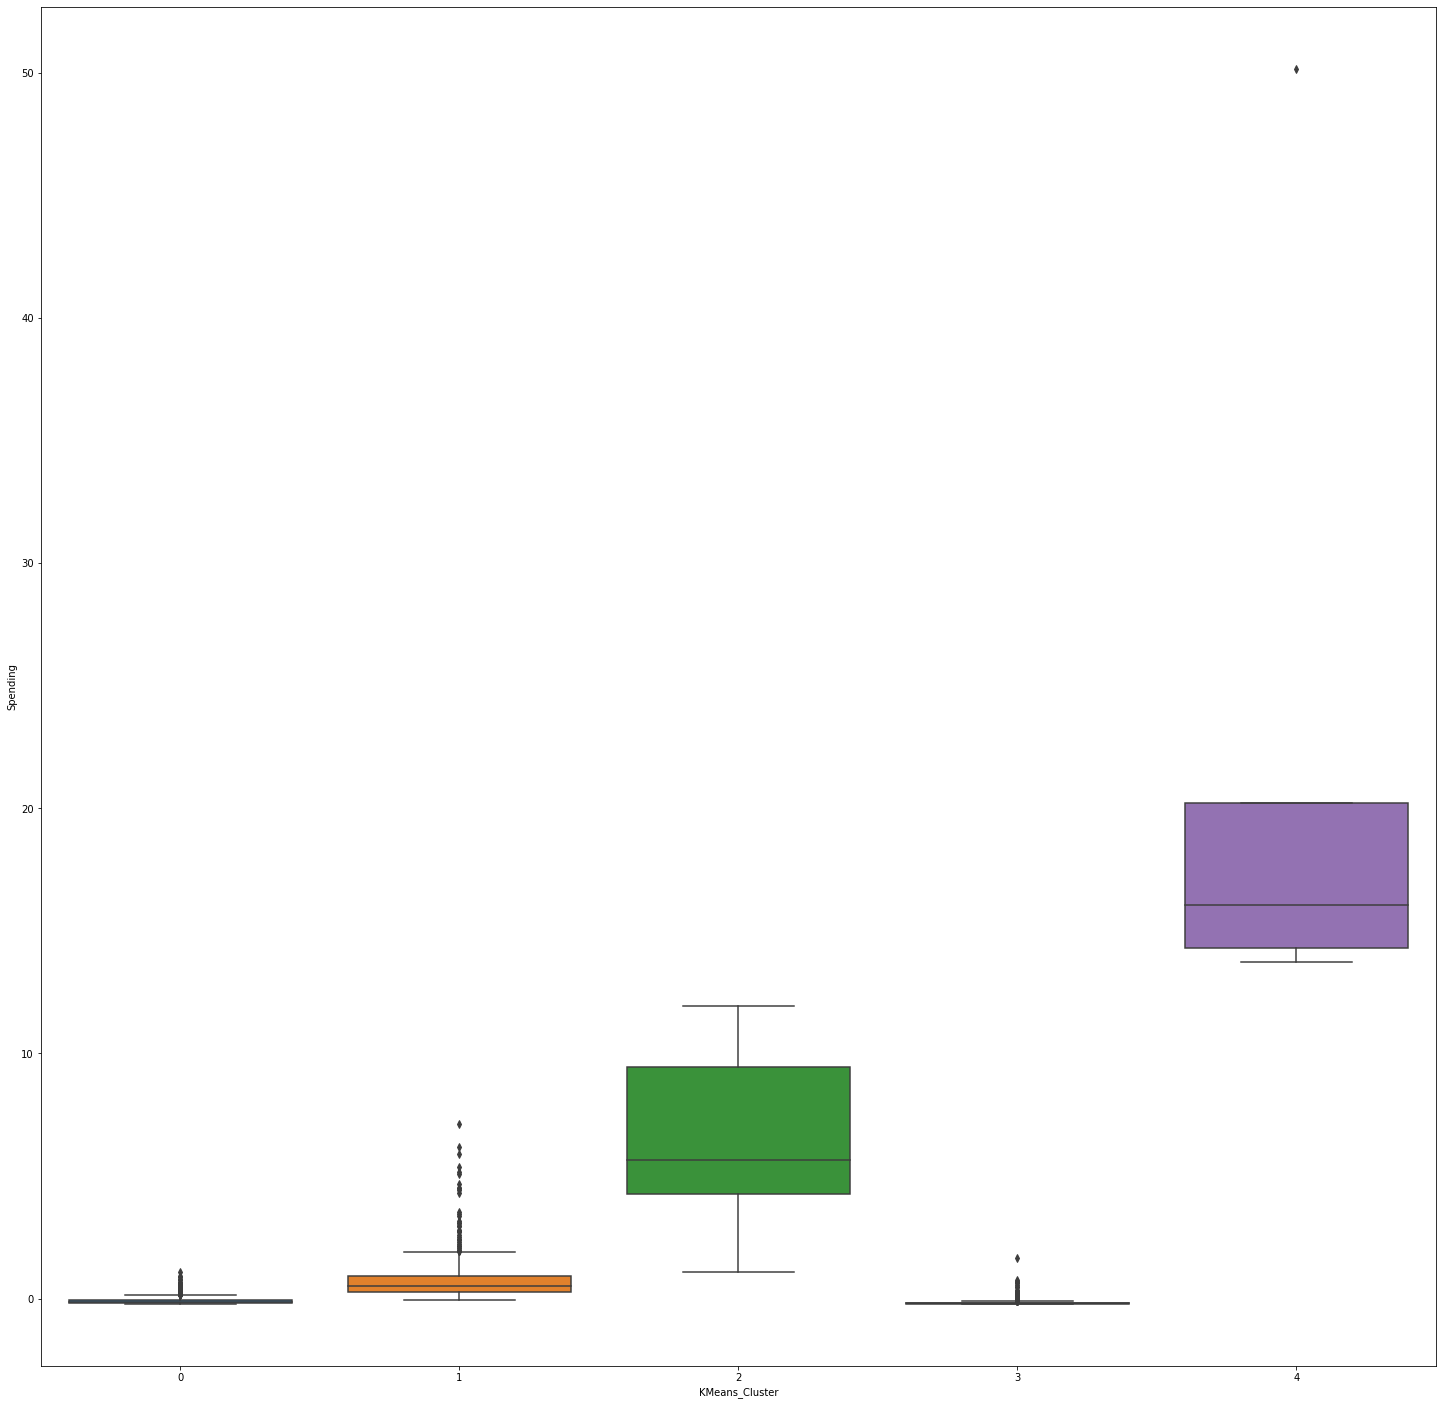

In [86]:
sns.boxplot(x='KMeans_Cluster',y='Spending',data=rfm3_scaled)

<AxesSubplot:xlabel='KMeans_Cluster', ylabel='recency'>

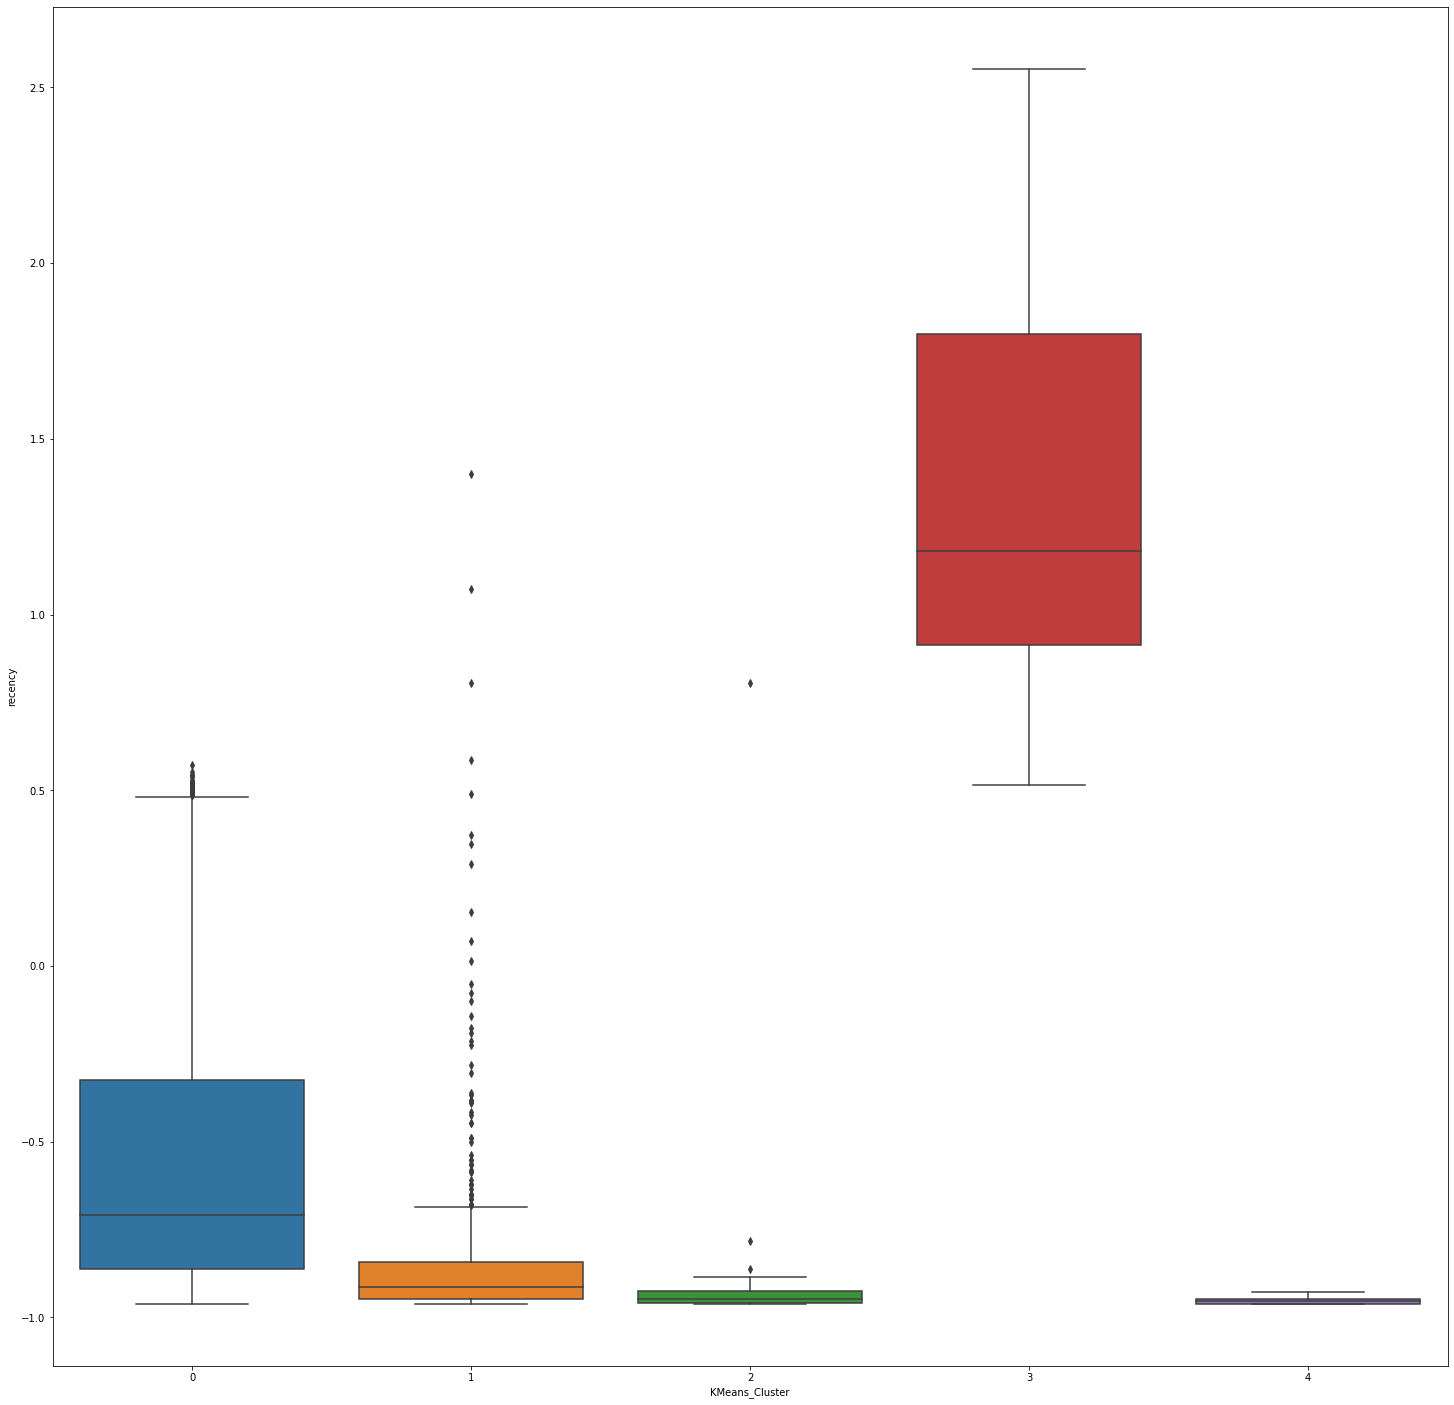

In [87]:
sns.boxplot(x='KMeans_Cluster',y='recency',data=rfm3_scaled)

<AxesSubplot:xlabel='KMeans_Cluster', ylabel='Purchase_Frequency'>

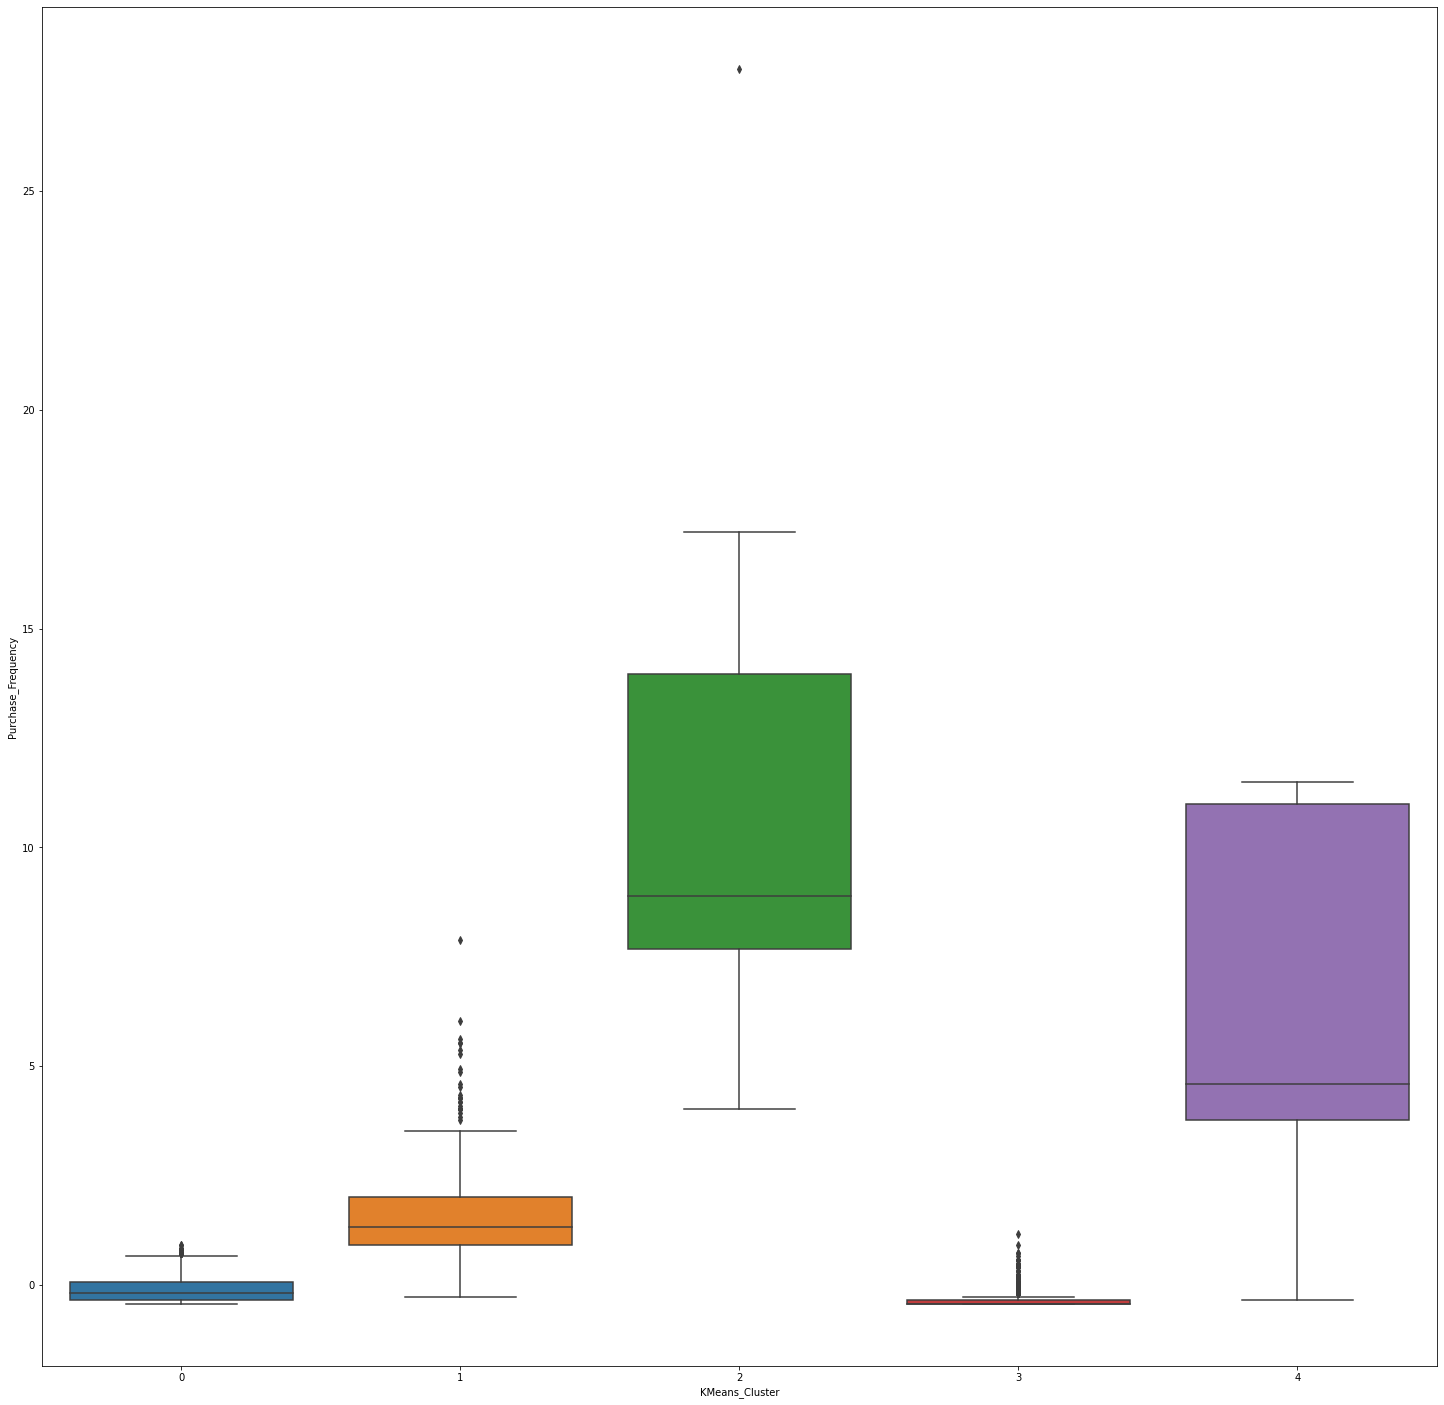

In [88]:
sns.boxplot(x='KMeans_Cluster',y='Purchase_Frequency',data=rfm3_scaled)

In [89]:
# RFM Segments vs. Clusters from KMeans
second=rfm3_scaled.groupby(['KMeans_Cluster','Segment_name'])['KMeans_Cluster'].count()
second.head(100)

KMeans_Cluster  Segment_name      
0               champion               185
                needing_attention1     360
                needing_attention2    2205
                potential1             520
1               champion               298
                lost1                    2
                needing_attention1     146
                needing_attention2       2
2               champion                16
                needing_attention1       3
3               lost1                 1078
                lost2                    4
                needing_attention1      15
                needing_attention2     511
4               champion                 4
                potential1               1
Name: KMeans_Cluster, dtype: int64

In [115]:
rfm4 = pd.merge(rfm3_scaled, segment_2_final, how="left", on=["Customer ID"])
rfm4=rfm4.drop(['Colors'],axis=1)
rfm4.head()

,Customer ID,Segment_name,Spending_x,Purchase_Frequency_x,recency_x,cluster,KMeans_Cluster,recency_y,Spending_y,Purchase_Frequency_y
0,12747.0,champion,0.540141,1.660052,-0.957423,2,1,2.0,9276.54,26
1,12748.0,champion,4.457811,27.798019,-0.962186,1,2,1.0,56599.39,337
2,12749.0,champion,0.343179,0.231288,-0.947896,0,0,4.0,6897.36,9
3,12820.0,champion,-0.005172,0.399378,-0.952659,0,0,3.0,2689.52,11
4,12826.0,champion,0.016868,0.483423,-0.952659,0,0,3.0,2955.75,12


In [145]:
rfm4_counts= rfm4.groupby(['KMeans_Cluster']).count()
print(rfm4_counts['Customer ID'])
#Calculating the sum of the frequency
cluster_sum=rfm4_counts.sum()

#Normalizing the frequency
cluster_prct=rfm4_counts['Customer ID'].apply(lambda x: 100*x/cluster_sum)

print(cluster_prct['Customer ID'])

KMeans_Cluster
0    3270
1     448
2      19
3    1608
4       5
Name: Customer ID, dtype: int64
KMeans_Cluster
0    61.121495
1     8.373832
2     0.355140
3    30.056075
4     0.093458
Name: Customer ID, dtype: float64


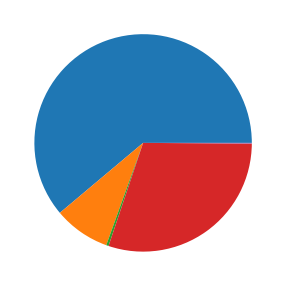

In [136]:
# Creating pie chart of Clusters
fig = plt.figure(figsize =(5, 5))
plt.pie(rfm4_counts['Customer ID'])
 
# show plot
plt.show()

In [110]:
rfm4_max = rfm4.groupby(['KMeans_Cluster']).max().round(2)
rfm4_max

,recency_y,Spending_y,Purchase_Frequency_y
KMeans_Cluster,,,
0,323.0,16075.42,17
1,497.0,88704.32,100
2,372.0,147142.77,337
3,739.0,22710.20,20
4,8.0,608821.65,143


In [109]:
rfm4=rfm4.drop(['Spending_x','Purchase_Frequency_x','recency_x','cluster','Customer ID','Segment_name'],axis=1)
rfm4_mean = rfm4.groupby(['KMeans_Cluster']).mean().round(2)
rfm4_mean

,recency_y,Spending_y,Purchase_Frequency_y
KMeans_Cluster,,,
0,87.39,1582.00,4.76
1,29.75,12400.39,25.60
2,26.26,78434.67,134.84
3,489.07,689.08,2.13
4,3.40,279270.72,78.80


In [ ]:
Findings and Conclusion:
    - Optimal Clusters identified with Elbow or Silhouette scores was different compared to RFM segments identified with quartiles scores
    - Also there is overlap of segments and clusters from the different approaches
    - 5 clusters identified from the data are
        - Cluster 0: Customer group who bought fairly recently, but fewer number of times and spending lower compared to others
        - Cluster 1: Customers who have recently purchased fairly high value products and did not repeat purchasing 
        - Cluster 2: Customers who have high repeat purchases and higher spendings, and recently purchased
        - Cluster 3: These Customers have not purchased in a very long time and have high churn while spending very little
        - Cluster 4: This is the best group of customers who buy very frequently and spent the most. Also they bought very recently
    - Online Retailer has over 61% of Customers in Cluster 0. A Marketing plan to drive this customer base to buy more frequently
    like utilising recommenders, coupon offerings for related recent purchases, will increase assist in growing Online retailer
    - 30% of customers have not purchased in recently. Online retailer is likely to lose this segment. Nurture campaigns 
    may assist in bringing back this group
    - Cluster 1 makes up 8% of customers who did not purchase repeatedly.But they spent fairly recent and bought high value 
    products.This group may be the dissatisfied customers. A campaign for feedback and acting upon feedback, will help to keep
    this customer base with Online retailer
    